In [1]:
# !pip install oolearning --upgrade

In [2]:
import math
import os
import time

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

import oolearning as oo
from helpers import DataFrameSelector, CustomLogTransform, ChooserTransform, CombineAgeHoursTransform

# TODO: incorporate Checklist from Appendix B
print(os.getcwd())

/Users/shanekercheval/personal_repos/udacity/data_scientist_nanodegree/projects/p1_charityml/custom


In [3]:
working_directory = os.path.join(os.getcwd(), '../')
csv_file = os.path.join(working_directory, 'census.csv')
target_variable = 'income'
positive_class = '>50K'
negative_class = '<=50K'

#target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
 #                                                  map_numeric_target=target_mapping)

# look at data
explore.dataset.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [4]:
explore.numeric_summary()

,count,nulls,perc_nulls,num_zeros,perc_zeros,mean,st_dev,coef of var,skewness,kurtosis,min,10%,25%,50%,75%,90%,max
age,45222,0,0.0,0,0.000,38.548,13.218,0.343,0.533,-0.156,17.0,22.0,28.0,37.0,47.0,57.0,90.0
education-num,45222,0,0.0,0,0.000,10.118,2.553,0.252,-0.311,0.635,1.0,7.0,9.0,10.0,13.0,13.0,16.0
capital-gain,45222,0,0.0,41432,0.916,1101.430,7506.430,6.815,11.789,150.151,0.0,0.0,0.0,0.0,0.0,0.0,99999.0
capital-loss,45222,0,0.0,43082,0.953,88.595,404.956,4.571,4.516,19.364,0.0,0.0,0.0,0.0,0.0,0.0,4356.0
hours-per-week,45222,0,0.0,0,0.000,40.938,12.008,0.293,0.341,3.201,1.0,25.0,40.0,40.0,45.0,55.0,99.0


In [5]:
explore.categoric_summary()

,count,nulls,perc_nulls,top,unique,perc_unique
workclass,45222,0,0.0,Private,7,0.000
education_level,45222,0,0.0,HS-grad,16,0.000
marital-status,45222,0,0.0,Married-civ-spouse,7,0.000
occupation,45222,0,0.0,Craft-repair,14,0.000
relationship,45222,0,0.0,Husband,6,0.000
race,45222,0,0.0,White,5,0.000
sex,45222,0,0.0,Male,2,0.000
native-country,45222,0,0.0,United-States,41,0.001
income,45222,0,0.0,<=50K,2,0.000


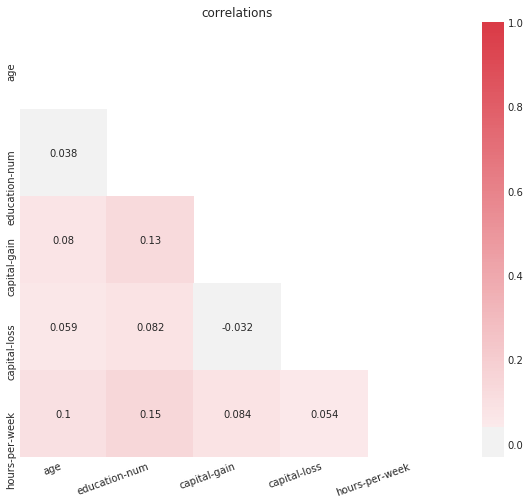

In [6]:
explore.plot_correlation_heatmap()

In [ ]:
# NOTE: since I will be cross-validating transformations e.g. GridSearchCV, it typically won't work to
# one-hot-encode during cross-validation because the hold fold will tend to have categoric values that
# were found in the training folds, and therefore will break during transformation because it will encode
# a value (i.e. add a column) that didn't exist in the training folds.
# So, for this, we need to fit ALL data. Then, below if we have new data e.g. Kaggle, we have to apply
# the same pipeline (i.e.  cat_encoding_pipeline.transform()
# TODO: this breaks though if there are any categorical features with missing values
one_hot_transformer = oo.DummyEncodeTransformer(encoding=oo.CategoricalEncoding.ONE_HOT)
transformed_data = one_hot_transformer.fit_transform(explore.dataset.drop(columns=target_variable))
transformed_data[target_variable] = explore.dataset[target_variable]

# split data into training/test sets
splitter = oo.ClassificationStratifiedDataSplitter(holdout_ratio=0.20)  # set aside 20% of the data for the holdout set
training_indexes, holdout_indexes = splitter.split(target_values=explore.dataset[target_variable])

training_y = transformed_data.iloc[training_indexes][target_variable].apply(lambda x: 1 if x == positive_class else 0)
training_x = transformed_data.iloc[training_indexes].drop(columns=target_variable)

holdout_y = transformed_data.iloc[holdout_indexes][target_variable].apply(lambda x: 1 if x == positive_class else 0)
holdout_x = transformed_data.iloc[holdout_indexes].drop(columns=target_variable)

cap_gain_loss_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribute_names=['capital-gain', 'capital-loss'])),
        ('imputer', Imputer()),
        ('custom_transform', CustomLogTransform()),
#        ('attribs_adder', CombinedAttributesAdder()),
        ('custom_scaler', ChooserTransform()),
    ])

# build transformation pipeline
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribute_names=['age', 'education-num', 'hours-per-week'])),
        ('imputer', Imputer()),
#        ('attribs_adder', CombinedAttributesAdder()),
        ('combine_agehours', CombineAgeHoursTransform()),
        ('custom_scaler', ChooserTransform()),

    ])
append_categoricals = Pipeline([
        ('append_cats', DataFrameSelector(attribute_names=one_hot_transformer.encoded_columns))
    ])

transformations_pipeline = FeatureUnion(transformer_list=[
        ("cap_gain_loss_pipeline", cap_gain_loss_pipeline),
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", append_categoricals),
    ])

#temp = full_pipeline.fit_transform(X=training_x, y=training_y)
#temp[0:9]
#explore.dataset.iloc[training_indexes].head(10)


# define models and hyper-parameters to tune

# tune models via cross validation on training set

my_scorer = make_scorer(roc_auc_score, greater_is_better=True)

transformation_parameters = {
        # 'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'pca_chooser__base_transformer': [PCA(n_components=None, random_state=42), None],
         'preparation__cap_gain_loss_pipeline__custom_transform__base': [None, math.e],
         'preparation__cap_gain_loss_pipeline__custom_scaler__base_transformer': [MinMaxScaler()],#, StandardScaler()],
         'preparation__num_pipeline__custom_scaler__base_transformer': [MinMaxScaler()],#, StandardScaler()],
         'preparation__num_pipeline__combine_agehours__combine': [True, False],
#         'model__': list(range(1, len(feature_importances) + 1)),
    }

models = [
          #LogisticRegression(random_state=42),
          #ExtraTreesClassifier(random_state=42),
          #RandomForestClassifier(random_state=42),
          AdaBoostClassifier(random_state=42),
          XGBClassifier(random_state=42, objective='binary:logistic')
         ]
model_param_dicts = [
        # {
        #  # Logistic Regression
        #  # TODO: add
        #
        # },
#         {
#          # Extra Trees Classifier
#          'model__max_features': [80, 85, 100],
#          'model__min_samples_leaf':[7, 10, 15],
#          'model__max_depth': [40, 50, 75],
#         },
#         {
#          # Random Forest Classifier
#          'model__n_estimators': [75, 100, 125],
#          'model__max_features': [65, 70],
#          'model__min_samples_leaf':[3, 5, 10],
#         },
        {
         # Adaboost Classifier
         'model__n_estimators': [400, 500, 600],
         'model__learning_rate': [1.5, 2, 5],
        },
        {
         # Adaboost Classifier
         'model__colsample_bytree': [0.3, 0.4, 0.5],
         'model__subsample': [0.9, 1.0],
         'model__max_depth': [4, 9, 14],
        },
    ]

def search(X, y, models: list, model_param_dicts: list, scorer, transformer_pipeline):
    assert len(models) == len(model_param_dicts)

    best_model_params = None
    best_score = 0 # assumes higher score value is better
    print('Starting....')

    for model, model_param_dict in zip(models, model_param_dicts):
        time_start = time.time()

        full_pipeline = Pipeline([
            ('preparation', transformer_pipeline),
            ('pca_chooser', ChooserTransform()),
            #    ('feature_selection', TopFeatureSelector(feature_importances, k)),
            ('model', model)
        ])

        param_grid = [{**transformation_parameters, **model_param_dict}]

    #model = RandomForestClassifier(random_state=42)
    # train across 5 folds, that's a total of (12+6)*5=90 rounds of training
        grid_search = GridSearchCV(estimator=full_pipeline,
                                   param_grid=param_grid,
                                   cv=RepeatedKFold(n_splits=5, n_repeats=1),
                                   scoring=scorer,
                                   return_train_score=True,
                                   n_jobs=-1,
                                   verbose=0)
        grid_search.fit(X, y)
        time_end = time.time()

        # cvres = grid_search.cv_results_
        # for mean_score, std_score, params in zip(cvres["mean_test_score"], cvres["std_test_score"], cvres["params"]):
        #     print(mean_score, std_score, params)

        print('-------------------------------')
        print('Model: ' + type(model).__name__)
        print('Best Score ({0}): {1}'.format(str(grid_search.scorer_), str(grid_search.best_score_)))
        print('Best Params: ' + str(grid_search.best_params_))
        print('Time: {}s'.format(round(time_start-time_end, 1)))

        if grid_search.best_score_ > best_score:
            best_model_params = grid_search.best_params_

    return best_model_params


best_params = search(training_x, training_y, models, model_param_dicts, my_scorer, transformations_pipeline)
# take the best hyper-parameters, refit on entire training set, and predict on test set

# compare the best models

# look at feature importance across models

Starting....
